In [4]:
!pip install tmtoolkit
!pip install gspread

     |████████████████████████████████| 19.9 MB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 20.1 MB 42.2 MB/s eta 0:00:01
     |████████████████████████████████| 103 kB 45.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 13.7 MB/s eta 0:00:01     |████████████████████████▏       | 1.7 MB 13.7 MB/s eta 0:00:01
     |████████████████████████████████| 22.1 MB 16.9 MB/s eta 0:00:01    |▊                               | 532 kB 16.9 MB/s eta 0:00:02
     |████████████████████████████████| 3.0 MB 41.8 MB/s eta 0:00:01
  Created wheel for globre: filename=globre-0.1.5-py3-none-any.whl size=19526 sha256=ee687a7286a418ad632acb6a16b9b279d2e2b400a813b8709cbf7d0404d7c700
  Stored in directory: /root/.cache/pip/wheels/40/95/37/5303ce04fce53b6e64ed74a3f0a0e9ea11c348cac0c5c42a76
Successfully built globre
  Attempting uninstall: numpy
    Found existing installation: numpy 1.16.4
    Uninstalling numpy-1.16.4:
      Successfully uninstalled numpy-1.16.4
     |█████████

In [5]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [6]:
!pip install --upgrade wandb

Requirement already up-to-date: wandb in /usr/local/lib/python3.7/dist-packages (0.8.36)


In [ ]:
!wandb login fcfc2eca6b5d76c9f5532e9ef9d320af69a388ed

In [ ]:
import gspread
'''
from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

gc=gspread.oauth()
'''
gc = gspread.service_account('/spell/.config/gspread/configuration.json')


worksheet = gc.open('Gpt Huggingface results').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
print(rows)

# Convert to a DataFrame and render.
import pandas as pd
df=pd.DataFrame.from_records(rows)
df.head()

In [ ]:
df.columns=["prompt","text"]
df.head()

In [ ]:
#remove the prompt from text
for index,row in df.iterrows():
  df.at[index,'text']=row['text'][len(row['prompt']):]
df.head()

In [11]:
#create document identifiers
df['id']=range(1,len(df)+1)
df['id']="document_"+df['id'].astype(str)
df.head()

,prompt,text,id
0,If God is defined as something that is all pow...,profound:\nThe potential exists to make any b...,document_1
1,If God is defined as something that is all pow...,serious: why believe in any of it when we kno...,document_2
2,If God is defined as something that is all pow...,potentially immense – maybe there's no real p...,document_3
3,If God is defined as something that is all pow...,profound because it would mean there's no rea...,document_4
4,If God is defined as something that is all pow...,obvious – we would need to find another word ...,document_5


In [12]:
df.to_csv('corpus.csv')

In [13]:
import random
random.seed(20191120)   # to make the sampling reproducible

import numpy as np
np.set_printoptions(precision=5)

from tmtoolkit.corpus import Corpus


In [14]:
#acorpus=Corpus()
#acorpus.add_tabular('corpus.csv','id','text')

In [15]:
corpus=Corpus()
for index,row in df.iterrows():
    corpus.add_doc(doc_label=row['id'],doc_text=row['text'])



In [16]:
from tmtoolkit.preprocess import TMPreproc

preproc = TMPreproc(corpus)
preproc.pos_tag() \
    .lemmatize() \
    .tokens_to_lowercase() \
    .remove_special_chars_in_tokens()

<TMPreproc [70 documents]>

In [17]:
print(preproc.n_docs)
print(preproc.vocabulary_size)

70
2808


In [18]:
dtm=preproc.dtm

In [19]:
dtm

<70x2808 sparse matrix of type '<class 'numpy.int32'>'
	with 15033 stored elements in Compressed Sparse Row format>

In [ ]:
print(dtm)

In [20]:

sweep_config={
    "method":"random",
    "metric":{
        "name":"coherence",
        "goal":"maximize"
    },
    "parameters":{
        "num_topics":{
            "values":[10,20,30,40,50]
        },
        'random_state':{
            "values":[50,52,54,56,58,60]
        },
        'update_every':{
            "values":[1,5,10,50]
        },
        'chunksize':{
            "values":[10,20,30,40,50,60,70,80,90,100]
        },
        'passes':{
            'values':[10,20,30,40,50]
        },
        'minimum_probability':{
            'values':[0.01,0.03,0.04,0.05,0.08]
        },
        'per_word_topic':{
            'value':True
        }
    }
}


In [21]:
import wandb

In [22]:
sweep_id=wandb.sweep(sweep_config, entity="reedrw", project="gpt2-lda")

wandb: Network error resolved after 0:00:11.347655, resuming normal operation.


Create sweep with ID: m8me5ctw
Sweep URL: https://app.wandb.ai/reedrw/gpt2-lda/sweeps/m8me5ctw


In [23]:
def train():
    import warnings
    import logging
    import wandb
    from tmtoolkit.topicmod.tm_gensim import compute_models_parallel
    from tmtoolkit.topicmod.tm_lda import evaluate_topic_models
    from tmtoolkit.topicmod.evaluate import results_by_parameter


    # suppress the "INFO" messages and warnings from lda
    logger = logging.getLogger('lda')
    logger.addHandler(logging.NullHandler())
    logger.propagate = False

    warnings.filterwarnings('ignore')

    # set data to use


    # and fixed hyperparameters
    config_defaults = {
      "num_topics":10,
      "random_state":60,
      "update_every":50,
      "chunksize":10,
      "passes":40,
      "minimum_probability":.01,
      "per_word_topics":True
      }
    #wandb.init(config=config_defaults)
    config=config_defaults
    model = compute_models_parallel(dtm, constant_parameters=config)

    eval_results = evaluate_topic_models(dtm,
                                    varying_parameters=config)
    wandb.log({"eval_results":eval_results})
    return eval_results

In [27]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


In [28]:
# run directly through gensim
def gtrain():
  import wandb
  # Build LDA model 
  config_defaults={
      "num_topics":10,
      "random_state":60,
      "update_every":50,
      "chunksize":10,
      "passes":40,
      "minimum_probability":.01,
      "per_word_topics":True
  }
  wandb.init(config=config_defaults)
  #print("run:",run.config)
  #print("type",type(run))
  #print(wandb.config)
  #print("config=",config)
  config=wandb.config
  
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=config.num_topics, 
                                            random_state=config.random_state,
                                            update_every=config.update_every,
                                            chunksize=config.chunksize,
                                            passes=config.passes,
                                            alpha="auto",
                                            minimum_probability=config.minimum_probability,
                                            per_word_topics=config.per_word_topics)
  # Print the Keyword in the 10 topics
  wandb.log({"topics":lda_model.print_topics()})
  doc_lda = lda_model[corpus]
  coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence="c_v")
  coherence_lda = coherence_model_lda.get_coherence()
  print(coherence_lda,)
  wandb.log({"coherence":coherence_lda,
             "perplexity":lda_model.log_perplexity(corpus)})
  print(lda_model.print_topics()) 
  return lda_model

In [29]:
lda_model=gtrain()

NameError: name 'id2word' is not defined

In [24]:
lda_model=train()

AttributeError: 'str' object has no attribute 'copy'

In [36]:
vocab=np.array(preproc.vocabulary)

In [40]:
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words
print_ldamodel_topic_words(models[0][1].topic_word_,vocab,top_n=3)

topic_1
> #1. show (0.023524)
> #2. why (0.022141)
> #3. appear (0.015227)
topic_2
> #1.  (0.193160)
> #2. nt (0.033969)
> #3. be (0.029893)
topic_3
> #1.  (0.167291)
> #2. or (0.017757)
> #3. they (0.016178)
topic_4
> #1. take (0.023229)
> #2. help (0.017872)
> #3. use (0.016087)
topic_5
> #1. experience (0.012553)
> #2. offer (0.010986)
> #3. understand (0.009419)
topic_6
> #1. give (0.025134)
> #2. perhaps (0.019980)
> #3. where (0.017402)
topic_7
> #1. evolve (0.019935)
> #2. old (0.012689)
> #3. ie (0.011784)
topic_8
> #1. age (0.012016)
> #2. result (0.009615)
> #3. provide (0.007214)
topic_9
> #1. have (0.046627)
> #2. it (0.032325)
> #3. i (0.029464)
topic_10
> #1.  (0.075989)
> #2. build (0.014937)
> #3. see (0.012224)


In [41]:
var_params = [{'alpha': 1/(10**x)} for x in range(1, 5)]

const_params = {
    'n_iter': 500,
    'n_topics': 10,
    'random_state': 20191122  # to make results reproducible
}

models = compute_models_parallel(dtm,  # smaller DTM
                                 varying_parameters=var_params,
                                 constant_parameters=const_params)
models

[({'alpha': 0.1, 'n_iter': 500, 'n_topics': 10, 'random_state': 20191122},
  <lda.lda.LDA at 0x7f58a94a1dd0>),
 ({'alpha': 0.01, 'n_iter': 500, 'n_topics': 10, 'random_state': 20191122},
  <lda.lda.LDA at 0x7f58a94dcc90>),
 ({'alpha': 0.0001, 'n_iter': 500, 'n_topics': 10, 'random_state': 20191122},
  <lda.lda.LDA at 0x7f58a94c1350>),
 ({'alpha': 0.001, 'n_iter': 500, 'n_topics': 10, 'random_state': 20191122},
  <lda.lda.LDA at 0x7f58a94c1110>)]

In [42]:
var_params = [{'n_topics': k, 'alpha': 1/k} for k in range(20, 121, 10)]
var_params

[{'n_topics': 20, 'alpha': 0.05},
 {'n_topics': 30, 'alpha': 0.03333333333333333},
 {'n_topics': 40, 'alpha': 0.025},
 {'n_topics': 50, 'alpha': 0.02},
 {'n_topics': 60, 'alpha': 0.016666666666666666},
 {'n_topics': 70, 'alpha': 0.014285714285714285},
 {'n_topics': 80, 'alpha': 0.0125},
 {'n_topics': 90, 'alpha': 0.011111111111111112},
 {'n_topics': 100, 'alpha': 0.01},
 {'n_topics': 110, 'alpha': 0.00909090909090909},
 {'n_topics': 120, 'alpha': 0.008333333333333333}]

In [43]:
from tmtoolkit.topicmod.tm_lda import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import results_by_parameter

const_params = {
    'n_iter': 1000,
    'eta': 0.1,       # "eta" aka "beta"
    'random_state': 20191122  # to make results reproducible
}

eval_results = evaluate_topic_models(dtm,
                                     varying_parameters=var_params,
                                     constant_parameters=const_params,
                                     return_models=True)
eval_results[:3]  # only show first three models

[({'n_topics': 20,
   'alpha': 0.05,
   'n_iter': 1000,
   'eta': 0.1,
   'random_state': 20191122},
  {'model': <lda.lda.LDA at 0x7f58a95fbe10>,
   'cao_juan_2009': 0.16652314903166038,
   'arun_2010': 20.14521919804015,
   'coherence_mimno_2011': -4.593690265387515}),
 ({'n_topics': 30,
   'alpha': 0.03333333333333333,
   'n_iter': 1000,
   'eta': 0.1,
   'random_state': 20191122},
  {'model': <lda.lda.LDA at 0x7f58a91f40d0>,
   'cao_juan_2009': 0.2205377673766336,
   'arun_2010': 20.614157459277383,
   'coherence_mimno_2011': -5.888063616365986}),
 ({'n_topics': 40,
   'alpha': 0.025,
   'n_iter': 1000,
   'eta': 0.1,
   'random_state': 20191122},
  {'model': <lda.lda.LDA at 0x7f58a94dc290>,
   'cao_juan_2009': 0.2827250155137443,
   'arun_2010': 21.443725119563112,
   'coherence_mimno_2011': -7.285612615873663})]

In [44]:
eval_results_by_topics = results_by_parameter(eval_results, 'n_topics')
eval_results_by_topics[:3]  # again only the first three models

[(20,
  {'model': <lda.lda.LDA at 0x7f58a95fbe10>,
   'cao_juan_2009': 0.16652314903166038,
   'arun_2010': 20.14521919804015,
   'coherence_mimno_2011': -4.593690265387515}),
 (30,
  {'model': <lda.lda.LDA at 0x7f58a91f40d0>,
   'cao_juan_2009': 0.2205377673766336,
   'arun_2010': 20.614157459277383,
   'coherence_mimno_2011': -5.888063616365986}),
 (40,
  {'model': <lda.lda.LDA at 0x7f58a94dc290>,
   'cao_juan_2009': 0.2827250155137443,
   'arun_2010': 21.443725119563112,
   'coherence_mimno_2011': -7.285612615873663})]

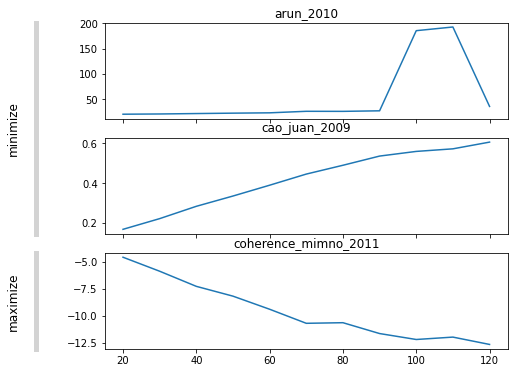

In [45]:
from tmtoolkit.topicmod.visualize import plot_eval_results

plot_eval_results(eval_results_by_topics);

In [47]:
best_tm = [m for k, m in eval_results_by_topics if k == 20][0]['model']

best_tm.n_topics, best_tm.alpha, best_tm.eta  # just to make sure

(20, 0.05, 0.1)

In [49]:
from tmtoolkit.bow.bow_stats import doc_lengths
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words

doc_lengths_bg = doc_lengths(dtm)
topic_labels = generate_topic_labels_from_top_words(
    best_tm.topic_word_,
    best_tm.doc_topic_,
    doc_lengths_bg,
    vocab,
    lambda_=0.6
)

topic_labels[:10]   # showing only the first 5 topics here

array(['1_show', '2_post', '3_face', '4_', '5_late', '6_dr', '7_organism',
       '8_deal', '9_alien', '10_car'], dtype='<U12')

In [54]:
from tmtoolkit.topicmod.model_io import ldamodel_top_topic_words

top_topic_word = ldamodel_top_topic_words(best_tm.topic_word_,
                                          vocab,
                                          row_labels=topic_labels)
top_topic_word[top_topic_word.index == '1_show']

,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10
topic,,,,,,,,,,
1_show,show (0.009259),occur (0.008116),example (0.006973),event (0.006973),biblical (0.00583),jesus (0.00583),build (0.00583),consider (0.00583),bible (0.00583),cause (0.00583)


In [50]:
from tmtoolkit.topicmod.model_stats import marginal_topic_distrib

marg_topic = marginal_topic_distrib(best_tm.doc_topic_, doc_lengths_bg)
marg_topic

array([0.03165, 0.01595, 0.01778, 0.65498, 0.02572, 0.007  , 0.03213,
       0.01219, 0.01298, 0.01213, 0.03306, 0.01473, 0.01219, 0.02742,
       0.01619, 0.01068, 0.01434, 0.01383, 0.02784, 0.0072 ])

In [51]:
# np.argsort() gives ascending order, hence reverse via [::-1]
topic_labels[np.argsort(marg_topic)[::-1][:5]]

array(['4_', '11_culture', '7_organism', '1_show', '19_allergy'],
      dtype='<U12')

In [56]:
from tmtoolkit.topicmod.model_stats import marginal_word_distrib

marg_word = marginal_word_distrib(best_tm.topic_word_, marg_topic)
vocab[np.argsort(marg_word)[::-1][:10]]

array(['', 'be', 'do', 'have', 'nt', 'it', 'i', 'in', 'make', 'but'],
      dtype='<U79')

In [57]:
from tmtoolkit.topicmod.model_stats import most_probable_words, least_probable_words

most_probable_words(vocab, best_tm.topic_word_,
                    best_tm.doc_topic_, doc_lengths_bg,
                    n=10)

array(['', 'be', 'do', 'have', 'nt', 'it', 'i', 'in', 'make', 'but'],
      dtype='<U79')

In [59]:
least_probable_words(vocab, best_tm.topic_word_,
                     best_tm.doc_topic_, doc_lengths_bg,
                     n=10)


array(['immemorial', 'things…', 'mandy', 'hit', 'fatherin',
       'superintelligences', 'negatively', 'arrive', 'magic', 'ketchum'],
      dtype='<U79')

In [60]:
from tmtoolkit.topicmod.evaluate import metric_coherence_mimno_2011

# use top 20 words per topic for metric
coh = metric_coherence_mimno_2011(best_tm.topic_word_, dtm, top_n=20)
coh

array([ -0.884  ,  -2.50281,  -3.77675,  -0.11246,  -0.91166, -14.99531,
        -1.00354,  -1.66555,  -3.03561,  -2.52442,  -0.85911,  -0.90084,
       -12.60548,  -0.68029,  -1.33867, -11.74474, -10.10062,  -4.1343 ,
        -0.814  , -17.28363])

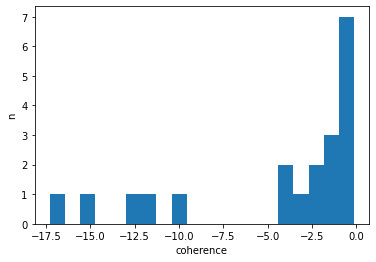

In [61]:
import matplotlib.pyplot as plt

plt.hist(coh, bins=20)
plt.xlabel('coherence')
plt.ylabel('n')
plt.show();

In [62]:
import numpy as np

top10_t_indices = np.argsort(coh)[::-1][:5]
bottom10_t_indices = np.argsort(coh)[:5]

topic_labels[top10_t_indices]

array(['4_', '14_age', '19_allergy', '11_culture', '1_show'], dtype='<U12')